In [10]:
import pandas as pd
import numpy as np
from Fingerprint.Hash2BitManager       import Hash2Bits, FindBitLength, GenerateFpsArray
from Kernels.Kernel          import funcTanimotoKernel_MMPKernel, funcTanimotoSklearn
from functools import partial
from Similarity.SimilarityHist import flattenTC
import seaborn as sns
import os
from scipy.special import rel_entr

def assign_vals(table, cols, new_col):
    for i, c in enumerate(cols):
        new_c = new_col[i]
        table[new_c] = 0
        for tid in table.index:
            data = pd.read_csv('./Dataset/Data/%s.tsv'%tid, sep='\t', index_col=0)
            table.loc[tid, new_c] = data[c].max()

    return table

def MakeSimilarityHistogram(target, use_zero=True, core_only=True, del_zero=True):
    df_tlist = pd.read_csv('./Dataset/target_list.tsv', sep='\t', index_col='chembl_tid') 
    df_main = pd.read_csv('./Dataset/Data/%s.tsv'%target, sep='\t', index_col=0)
    df_ecfp = pd.read_csv('./Dataset/ECFP/%s.tsv'%target, sep='\t', index_col=0)

    len_c = FindBitLength(df_ecfp, ['core'])
    len_s = FindBitLength(df_ecfp, ['sub1', 'sub2', 'overlap'])

    mms = df_ecfp.loc[df_main.drop_duplicates(['core_id']).index,:]

    fpgen = Hash2Bits()
    
    if not core_only:
        fp = GenerateFpsArray(mms['core'], nbits=len_c) 
        mat = funcTanimotoSklearn(fp, fp)
        sim = flattenTC(mat)
        #sim = np.max(mat, axis=1).reshape(-1)
        
    else:
        fp = fpgen.GetMMPfingerprints_DF_unfold(df_ecfp, ['core', 'sub1', 'sub2', 'overlap'], nbits=[len_c, len_s], overlap='concat')
        simfunc = partial(funcTanimotoKernel_MMPKernel, len_c=len_c)
        mat = simfunc(fp,fp)
        sim = flattenTC(mat)
        #sim = np.max(mat, axis=1).reshape(-1)
    
    sim = np.array(sim)
    
    if del_zero:
        sim  = sim[np.where(sim>0)[0]]
        bins = [0.00000001] + [0.1*i for i in range(1, 10)]
    
    else:
        bins = [0.1*i for i in range(10)]
        
    hist = np.histogram(sim, bins=bins, density=True)
    return hist

def kl_divergence(p, q):
	return sum(rel_entr(p,q))

def js_divergence(p, q):
    
    m = 0.5 * (p + q)
    
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)


def histogram_intersection(p, q):
    return sum([min(p_bin, q_bin) for p_bin, q_bin in zip(p, q)])

from itertools import product

def pairwise_calculation(func, labels, values):
    vals = np.array([func(i,j) for i, j in product(values, values)]).reshape(len(labels),-1)
    return pd.DataFrame(vals, index=labels, columns=labels)

In [11]:
svm     = pd.read_csv('./Score_wodirection_trtssplit/SVM/mean.tsv', sep='\t', index_col=0)
xgb     = pd.read_csv('./Score_wodirection_trtssplit/XGBoost/mean.tsv', sep='\t', index_col=0)
rf      = pd.read_csv('./Score_wodirection_trtssplit/Random_Forest/mean.tsv', sep='\t', index_col=0)
fcn     = pd.read_csv('./Score_wodirection_trtssplit/FCNN/mean.tsv', sep='\t', index_col=0)
fcn_sep = pd.read_csv('./Score_wodirection_trtssplit/FCNN_separated/mean.tsv', sep='\t', index_col=0)
mpn     = pd.read_csv('./Score_wodirection_trtssplit/MPNN/mean.tsv', sep='\t', index_col=0)
mpn_sep = pd.read_csv('./Score_wodirection_trtssplit/MPNN_separated/mean.tsv', sep='\t', index_col=0)
nn1     = pd.read_csv('./Score_wodirection_trtssplit/1NN/SVM/mean.tsv', sep='\t', index_col=0)
nn5     = pd.read_csv('./Score_wodirection_trtssplit/5NN/SVM/mean.tsv', sep='\t', index_col=0)


svm     = assign_vals(svm, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
xgb     = assign_vals(xgb, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
rf      = assign_vals(rf , cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
fcn     = assign_vals(fcn, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
fcn_sep = assign_vals(fcn_sep, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
mpn     = assign_vals(mpn, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
mpn_sep = assign_vals(mpn_sep, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
nn1     = assign_vals(nn1, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
nn5     = assign_vals(nn5, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])


svm['model']     = 'svm'
xgb['model']     = 'xgb'
rf['model']      = 'rf'
fcn['model']     = 'fcnn'
fcn_sep['model'] = 'fcnn_sep'
mpn['model']     = 'mpnn'
mpn_sep['model'] = 'mpnn_sep'
nn1['model']     = '1NN'
nn5['model']     = '5NN'


all_score = pd.concat([svm, xgb, rf, fcn, fcn_sep, mpn, mpn_sep, nn1, nn5])

In [12]:
from collections import defaultdict

tnames = defaultdict(list)
scores = defaultdict(list)

for name, ml in zip(['svm', 'rf', 'fcn_sep', 'mpn_sep'], [svm, rf, fcn_sep, mpn_sep]):
    tnames[name] = list(ml.sort_values('matthews_coeff', ascending=False).index[:40])
    scores[name] = list(ml.sort_values('matthews_coeff', ascending=False)['matthews_coeff'].iloc[:40])
    
tnames = pd.DataFrame.from_dict(tnames, orient='columns')
scores = pd.DataFrame.from_dict(scores, orient='columns')

In [13]:
tnames

,svm,rf,fcn_sep,mpn_sep
0,CHEMBL333,CHEMBL3018,CHEMBL3018,CHEMBL4072
1,CHEMBL4523,CHEMBL5407,CHEMBL204,CHEMBL204
2,CHEMBL1800,CHEMBL4523,CHEMBL335,CHEMBL3018
3,CHEMBL5407,CHEMBL333,CHEMBL1926488,CHEMBL333
4,CHEMBL2954,CHEMBL3991,CHEMBL3991,CHEMBL5023
5,CHEMBL3991,CHEMBL1741186,CHEMBL1741186,CHEMBL5407
6,CHEMBL2820,CHEMBL204,CHEMBL237,CHEMBL253
7,CHEMBL1926488,CHEMBL1800,CHEMBL244,CHEMBL1741186
8,CHEMBL204,CHEMBL2954,CHEMBL3759,CHEMBL238
9,CHEMBL3729,CHEMBL4072,CHEMBL214,CHEMBL2147


In [14]:
scores

,svm,rf,fcn_sep,mpn_sep
0,1.000,1.000,1.000,0.914
1,0.948,0.952,0.884,0.858
2,0.923,0.948,0.874,0.853
3,0.897,0.904,0.857,0.776
4,0.885,0.902,0.857,0.765
5,0.877,0.898,0.856,0.749
6,0.869,0.890,0.848,0.726
7,0.857,0.865,0.839,0.718
8,0.853,0.848,0.839,0.716
9,0.850,0.840,0.837,0.708


In [15]:
df = tnames.iloc[:10,:]
stats = pd.DataFrame(pd.Series(df.values.reshape(-1)).value_counts())
stats['ml'] = ''

for target in stats.index:
    for ml in df.columns:
        if any(target == df[ml]):
            obj = stats.loc[target,'ml']
            stats.loc[target,'ml'] = obj + '  ' + ml
            
stats['bool'] = [True if i in ['  fcn_sep', '  mpn_sep'] else False for i in stats['ml']]

flags = []

for target, series in stats.iterrows():
    
    b = series['bool']
    
    if not b:
        flags += [True]
        continue
    
    metric = stats.loc[target, 'ml'][2:] 
    
    metric_idx = np.where(df[metric]==target)[0]
    svm_idx = np.where(tnames['svm']==target)[0]
    rf_idx  = np.where(tnames['rf']==target)[0]
    
    
    metric_score = scores.loc[metric_idx[0], metric]
    
    if svm_idx.shape[0]>0:
        svm_score = scores.loc[svm_idx[0], 'svm']
    else:
        svm_score = 0
        
    if rf_idx.shape[0]>0:
        rf_score  = scores.loc[rf_idx[0] , 'rf']
    else:
        rf_score = 0
    
    print(metric_score, svm_score, rf_score)
    flag = bool( (metric_score > svm_score) * (metric_score > rf_score) )
    
    flags += [flag]
    
stats['flag'] = flags
    
    

0.8740000000000001 0.8140000000000001 0.627
0.726 0.746 0.7829999999999999
0.716 0.748 0.581
0.8370000000000001 0.62 0.5720000000000001
0.848 0.69 0.662
0.708 0.8340000000000001 0.684
0.765 0.8490000000000001 0.677
0.8390000000000001 0.72 0.73
0.8390000000000001 0.7659999999999999 0.718


In [16]:
stats = stats.loc[stats['flag'], :]
stats

,0,ml,bool,flag
CHEMBL204,4,svm rf fcn_sep mpn_sep,False,True
CHEMBL3991,3,svm rf fcn_sep,False,True
CHEMBL5407,3,svm rf mpn_sep,False,True
CHEMBL333,3,svm rf mpn_sep,False,True
CHEMBL1741186,3,rf fcn_sep mpn_sep,False,True
CHEMBL3018,3,rf fcn_sep mpn_sep,False,True
CHEMBL1926488,2,svm fcn_sep,False,True
CHEMBL2954,2,svm rf,False,True
CHEMBL4523,2,svm rf,False,True
CHEMBL1800,2,svm rf,False,True


In [17]:
dict_hist      = {t:MakeSimilarityHistogram(target=t, core_only=False)[0] for t in stats.index}
dict_hist_core = {t:MakeSimilarityHistogram(target=t, core_only=True)[0] for t in stats.index}

/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: Sett

    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: Sett

    $ Overlap option is selected as concat
    $ Overlap option is selected as concat
    $ Overlap option is selected as concat
    $ Overlap option is selected as concat
    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat
    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat
    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat
    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat
    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


# Compare histogram

In [18]:
classic = [2954, 1800, 4523, 2820, 3729] #[1800, 3991, 3018, 1741186, 1926488, 3729, 2820, 1795117, 5113]
nn_both = [] #[244, 237]
nn_fcn  = [244, 335, 214, 237, 3759] #[214, 5023]
nn_mpn  = [] #[251, 236, 344]
allml   = [204, 3018, 5407, 1741186, 3991, 333, 1926488, 4072] #[204, 5407, 2954, 333, 4523, 4072, 2147, 335, 255]

col = ['CHEMBL%d'%i for i in classic+nn_both+nn_fcn+nn_mpn+allml]

## js_divergence

In [19]:
js   = pairwise_calculation(js_divergence, col, [dict_hist[c] for c in col])
js_c = pairwise_calculation(js_divergence, col, [dict_hist_core[c] for c in col])
js

,CHEMBL2954,CHEMBL1800,CHEMBL4523,CHEMBL2820,CHEMBL3729,CHEMBL244,CHEMBL335,CHEMBL214,CHEMBL237,CHEMBL3759,CHEMBL204,CHEMBL3018,CHEMBL5407,CHEMBL1741186,CHEMBL3991,CHEMBL333,CHEMBL1926488,CHEMBL4072
CHEMBL2954,0.000000,0.457943,0.197186,0.270286,0.289963,0.148474,0.418222,0.139194,0.089537,0.202079,0.133272,1.784916,0.136972,3.796292,0.861686,0.063320,1.001728,0.026989
CHEMBL1800,0.457943,0.000000,0.216783,0.216643,0.681892,0.805993,0.198570,0.700952,0.375469,0.392000,0.808504,1.258272,0.164544,2.798411,1.034453,0.471895,0.378246,0.353792
CHEMBL4523,0.197186,0.216783,0.000000,0.183743,0.686728,0.350302,0.210693,0.519796,0.117931,0.214456,0.382902,1.766513,0.122537,3.332220,1.290699,0.309819,0.439605,0.119133
CHEMBL2820,0.270286,0.216643,0.183743,0.000000,0.443005,0.696355,0.220373,0.432474,0.386234,0.122417,0.681553,1.004420,0.093932,2.475555,0.766599,0.344836,0.603000,0.173350
CHEMBL3729,0.289963,0.681892,0.686728,0.443005,0.000000,0.650488,0.732586,0.085448,0.534788,0.499966,0.568976,1.065225,0.290671,3.433308,0.190930,0.253815,1.611494,0.387624
CHEMBL244,0.148474,0.805993,0.350302,0.696355,0.650488,0.000000,0.807204,0.335197,0.120974,0.474894,0.007563,2.714948,0.450636,4.693333,1.430899,0.268641,1.199665,0.214861
CHEMBL335,0.418222,0.198570,0.210693,0.220373,0.732586,0.807204,0.000000,0.757274,0.377556,0.480427,0.834001,1.288734,0.207792,3.158466,1.142239,0.411338,0.618209,0.327924
CHEMBL214,0.139194,0.700952,0.519796,0.432474,0.085448,0.335197,0.757274,0.000000,0.343301,0.335213,0.271870,1.515122,0.257342,3.655605,0.476137,0.160009,1.475198,0.228983
CHEMBL237,0.089537,0.375469,0.117931,0.386234,0.534788,0.120974,0.377556,0.343301,0.000000,0.341450,0.142764,2.111335,0.176823,4.094030,1.205995,0.184016,0.801261,0.102131
CHEMBL3759,0.202079,0.392000,0.214456,0.122417,0.499966,0.474894,0.480427,0.335213,0.341450,0.000000,0.452007,1.467184,0.181372,2.682739,0.953808,0.277372,0.654690,0.109390


In [20]:
js.to_csv('./Score_wodirection_trtssplit/similarity_hist/js_div.tsv', sep='\t')
js_c.to_csv('./Score_wodirection_trtssplit/similarity_hist/js_div_core.tsv', sep='\t')

## histogram intersection

In [21]:
hi   = pairwise_calculation(histogram_intersection, col, [dict_hist[c] for c in col])
hi_c = pairwise_calculation(histogram_intersection, col, [dict_hist_core[c] for c in col])
hi

,CHEMBL2954,CHEMBL1800,CHEMBL4523,CHEMBL2820,CHEMBL3729,CHEMBL244,CHEMBL335,CHEMBL214,CHEMBL237,CHEMBL3759,CHEMBL204,CHEMBL3018,CHEMBL5407,CHEMBL1741186,CHEMBL3991,CHEMBL333,CHEMBL1926488,CHEMBL4072
CHEMBL2954,10.000001,7.795910,8.826978,8.200949,7.696538,8.557939,7.947446,8.671185,9.091748,8.473786,8.715177,4.538485,8.767966,2.781299,5.981792,9.348172,6.766061,9.517360
CHEMBL1800,7.795910,10.000000,8.339286,8.766046,7.495332,6.780277,8.916667,7.471257,7.727457,8.165093,6.937514,5.642857,8.698579,4.208333,6.106884,7.895605,8.398810,8.082883
CHEMBL4523,8.826978,8.339286,10.000001,8.351744,6.955086,8.289930,8.210854,7.872473,8.979730,8.808131,8.309186,4.817568,8.640333,3.698842,5.346847,8.591625,7.779280,9.190785
CHEMBL2820,8.200949,8.766046,8.351744,10.000000,8.157316,6.774066,9.095929,8.078590,7.721246,8.757427,6.931303,6.257246,8.993869,4.472050,6.666667,8.091655,7.753624,8.360044
CHEMBL3729,7.696538,7.495332,6.955086,8.157316,10.000000,6.578853,7.498716,8.896097,7.035226,7.477491,6.772183,6.476833,8.197255,2.814464,8.228577,8.002098,6.187068,7.539364
CHEMBL244,8.557939,6.780277,8.289930,6.774066,6.578853,10.000001,6.752526,7.642582,8.976859,7.639651,9.772258,3.117964,7.325905,2.130357,4.843943,8.084201,6.079980,8.411521
CHEMBL335,7.947446,8.916667,8.210854,9.095929,7.498716,6.752526,10.000000,7.528737,7.685749,7.937962,6.817089,5.662699,8.633143,3.968254,6.023120,8.012821,7.769842,7.981582
CHEMBL214,8.671185,7.471257,7.872473,8.078590,8.896097,7.642582,7.528737,10.000001,7.949529,8.424698,7.836446,5.401558,8.718808,2.736223,7.180213,8.958151,6.602860,8.504925
CHEMBL237,9.091748,7.727457,8.979730,7.721246,7.035226,8.976859,7.685749,7.949529,10.000001,8.371059,9.041422,4.037234,8.260989,2.678571,5.425532,8.577567,6.760639,9.128975
CHEMBL3759,8.473786,8.165093,8.808131,8.757427,7.477491,7.639651,7.937962,8.424698,8.371059,10.000001,7.798795,5.463971,8.723143,4.307513,6.269812,8.364393,7.660140,8.945538


In [22]:
hi.to_csv('./Score_wodirection_trtssplit/similarity_hist/hi_sim.tsv', sep='\t')
hi_c.to_csv('./Score_wodirection_trtssplit/similarity_hist/hi_sim_core.tsv', sep='\t')

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

def heatmap(df, outpath=None, cmap_rev=True):
    # Create a mask
    mask = None

    #Create a matplotlib colormap from the sns seagreen color palette
    cmap = sns.light_palette("blue", reverse=cmap_rev, as_cmap=True )
    # Normalize to the range of possible values from df["c"]
    norm = matplotlib.colors.Normalize(vmin=df.min().min(), vmax=df.max().max())
    # create a color dictionary (value in c : color from colormap) 
    colors = {}
    for cval in df.values.reshape(-1):
        colors.update({cval : cmap(norm(cval))})
        
    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(df, mask=mask, center=0, annot=True,
                fmt='.2f', square=True, cmap=cmap)

    if outpath==None:
        plt.show()
    else:
        plt.savefig(outpath)
        
    return ax

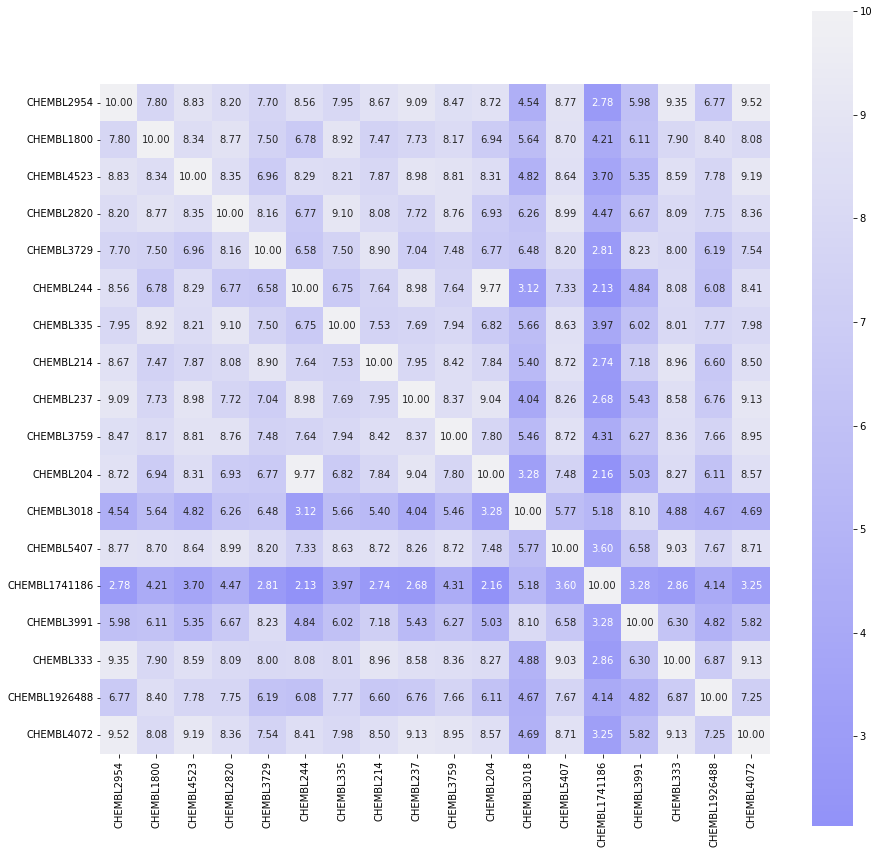

In [24]:
ax = heatmap(hi, outpath='./Score_wodirection_trtssplit/similarity_hist/heatmap_hi.svg')

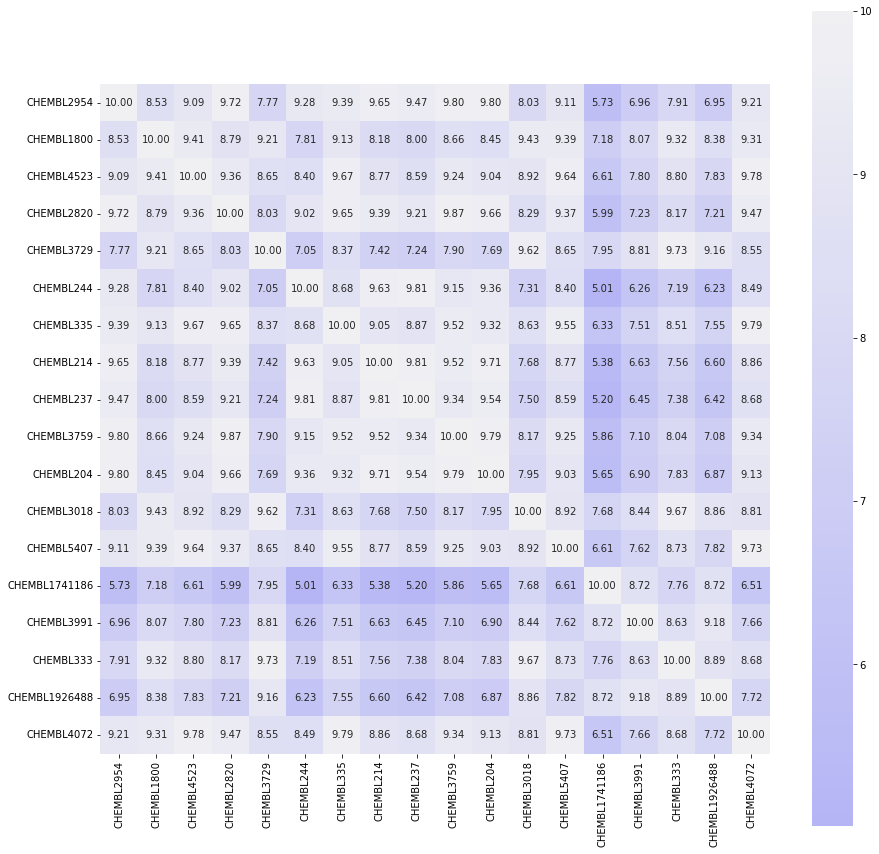

In [25]:
ax = heatmap(hi_c, outpath='./Score_wodirection_trtssplit/similarity_hist/heatmap_hi_core.svg')

In [26]:
def regional_average(val, r_from, r_to, c_from, c_to):
    
    val_sub = val[r_from:r_to, c_from:c_to]
    
    if r_from==c_from:
        ave = (val_sub.sum().sum() - np.diag(val_sub).sum()) / (val_sub.shape[0]*val_sub.shape[1]-np.diag(val_sub).shape[0])
    else:
        ave = val_sub.sum().sum() / (val_sub.shape[0]*val_sub.shape[1])
    return ave


def regional_median(val, r_from, r_to, c_from, c_to):
    
    val_sub = val[r_from:r_to, c_from:c_to]
    
    if r_from==c_from:
        triu = np.triu(val_sub,1).reshape(-1)
        med  = np.median(triu[np.where(triu>0)[0]])
    else:
        med  = np.median(val_sub.reshape(-1)) 
    return med
    

In [27]:
val = hi.values
idx = [0, 5, 10]

for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        ave = regional_average(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(ave, 2))

8.06
8.08
8.08
7.89


In [28]:
for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        med = regional_median(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(med, 2))

8.18
8.17
8.17
7.81


In [29]:
val = hi_c.values
for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        ave = regional_average(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(ave, 2))

8.86
8.77
8.77
9.34


In [30]:
for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        med = regional_median(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(med, 2))

8.94
9.02
9.02
9.43


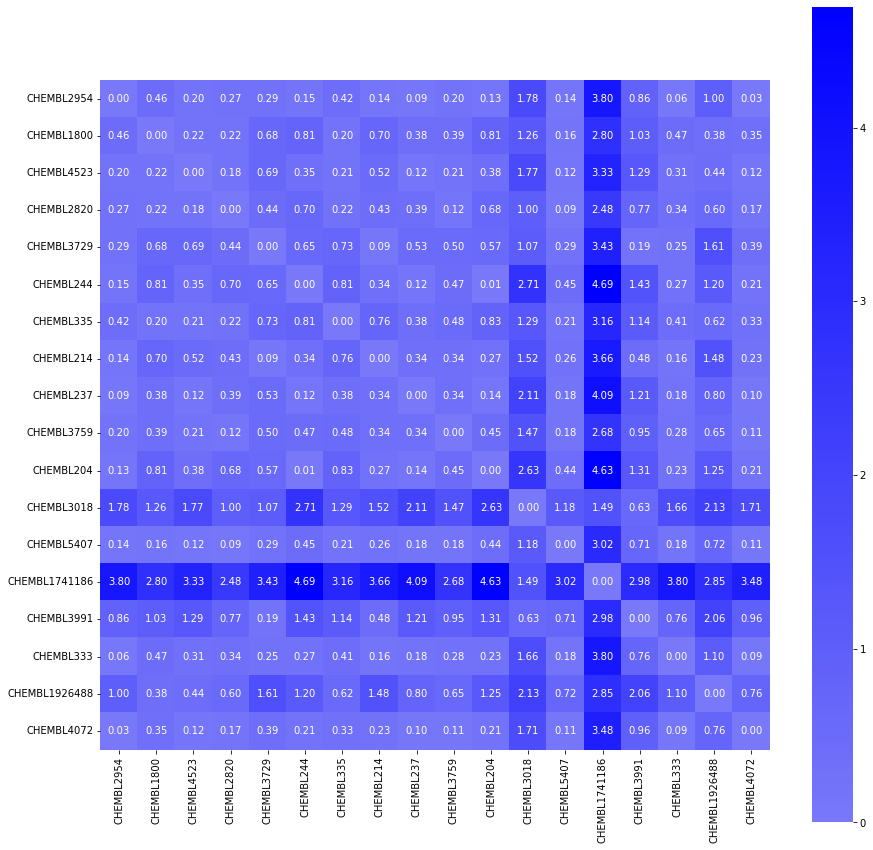

In [31]:
ax = heatmap(js, outpath='Score_wodirection_trtssplit/similarity_hist/heatmap_js.svg', cmap_rev=False)

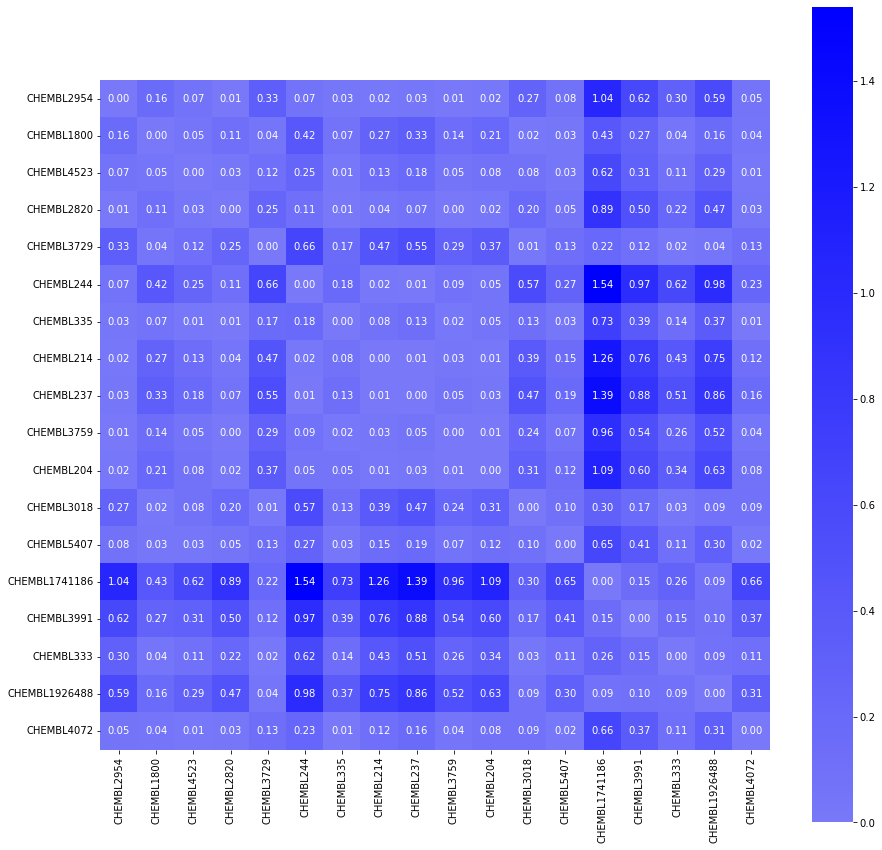

In [32]:
ax = heatmap(js_c, outpath='Score_wodirection_trtssplit/similarity_hist/heatmap_js_core.svg', cmap_rev=False)

In [33]:
val = js.values

for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        ave = regional_average(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(ave, 2))

0.36
0.37
0.37
0.44


In [34]:
for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        med = regional_median(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(med, 2))

0.28
0.38
0.38
0.36


In [35]:
val = js_c.values

for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        ave = regional_average(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(ave, 2))

0.12
0.18
0.18
0.06


In [36]:
for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        med = regional_median(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(med, 2))

0.09
0.11
0.11
0.04


# Target name

In [37]:
tlist = pd.read_csv('./Dataset/target_list.tsv', sep='\t', index_col='chembl_tid')

for tid in hi.keys():
    print(tid, ': ', tlist.loc[tid, 'primary_name'])

CHEMBL2954 :  Cathepsin S
CHEMBL1800 :  Corticotropin-releasing factor receptor 1
CHEMBL4523 :  Serine/threonine-protein kinase pim-2
CHEMBL2820 :  Coagulation factor XI
CHEMBL3729 :  Carbonic anhydrase 4
CHEMBL244 :  Coagulation factor X
CHEMBL335 :  Tyrosine-protein phosphatase non-receptor type 1
CHEMBL214 :  5-hydroxytryptamine receptor 1A
CHEMBL237 :  Kappa-type opioid receptor
CHEMBL3759 :  Histamine H4 receptor
CHEMBL204 :  Prothrombin
CHEMBL3018 :  Suppressor of tumorigenicity 14 protein
CHEMBL5407 :  Serine/threonine-protein kinase pim-3
CHEMBL1741186 :  Nuclear receptor ROR-gamma
CHEMBL3991 :  Coagulation factor VII
CHEMBL333 :  72 kDa type IV collagenase
CHEMBL1926488 :  Protoporphyrinogen oxidase
CHEMBL4072 :  Cathepsin B
